In [315]:
from mlrl.runners.dqn_runner import DQNRun
from mlrl.experiments.procgen_dqn import make_vectorised_procgen, create_rainbow_agent

In [316]:
folder = './sync/dqn/categorical_dqn_agent/run-16823527592836354'

import json

with open(folder + '/config.json') as f:
    config = json.load(f)

config

{'action_repeats': 4,
 'agent_name': 'categorical_dqn_agent',
 'collect_steps_per_iteration': 1,
 'discount': 0.999,
 'env': 'bigfish',
 'epsilon': 0.1,
 'epsilon_decay_steps': 250000,
 'epsilon_schedule': False,
 'eval_steps': 1000,
 'experience_batch_size': 64,
 'final_epsilon': 0.1,
 'frame_stack': 0,
 'grayscale': False,
 'initial_collect_steps': 500,
 'initial_epsilon': 1.0,
 'learning_rate': 0.00025,
 'max_epochs': 500,
 'metrics': [],
 'model_config': 'N/A',
 'n_collect_envs': 64,
 'n_eval_envs': 64,
 'n_video_envs': 12,
 'name': 'run',
 'optimiser_config': {'amsgrad': False,
  'beta_1': 0.8999999761581421,
  'beta_2': 0.9990000128746033,
  'decay': 0.0,
  'epsilon': 1e-07,
  'learning_rate': 0.0002500000118743628,
  'name': 'Adam'},
 'procgen_env_name': 'bigfish',
 'replay_buffer_capacity': 1024,
 'run_dir': './runs/categorical_dqn_agent/run-16823527592836354',
 'target_network_update_period': 10000,
 'train_steps_per_epoch': 20000,
 'video_seconds': 60}

In [317]:
env = make_vectorised_procgen(config, n_envs=1)
q_net, agent = create_rainbow_agent(env, config)

Building Categorical Q-Network weights...


In [318]:
q_vals, _ = q_net(env.current_time_step().observation)
q_vals.shape

TensorShape([1, 15, 51])

In [319]:
import re
from typing import Tuple


def parse_model_weights_string(path: str) -> Tuple[int, float]:
    pattern = r"sequential_best_(\d+)_(\d+\.\d+).index"

    match = re.match(pattern, path)

    if match:
        epoch = int(match.group(1))
        value = float(match.group(2))
        return epoch, value

    return None

In [320]:
from pathlib import Path

model_paths = [
    (str(path).replace('.index', ''), *values)
    for path in Path(f'{folder}/model_weights').glob('*')
    if path.is_file() and str(path).endswith('.index') 
        and (values := parse_model_weights_string(str(path.name))) is not None
]

In [321]:
model_paths = sorted(model_paths, key=lambda x: x[1])

In [322]:
path, epoch, ret_val = max(model_paths, key=lambda x: x[2])
path, epoch, ret_val

('sync/dqn/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_65_40.599998',
 65,
 40.599998)

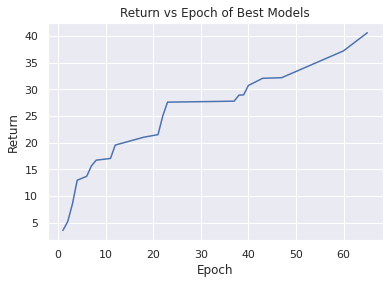

In [323]:
epochs = [epoch for _, epoch, _ in model_paths]
ret_vals = [ret_val for _, _, ret_val in model_paths]

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

plt.plot(epochs, ret_vals)
plt.xlabel('Epoch')
plt.ylabel('Return')
plt.title('Return vs Epoch of Best Models')
plt.show()

In [324]:
from typing import List, Tuple


def get_model_at_return_percentile(model_paths: List[Tuple[str, int, float]], percentile: float) -> Tuple[str, int, float]:
    sorted_paths = sorted(model_paths, key=lambda x: x[2])
    index = int(len(sorted_paths) * percentile)
    return model_paths[index]

In [325]:
get_model_at_return_percentile(model_paths, 0.75)

('sync/dqn/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_40_30.722221',
 40,
 30.722221)

In [326]:
path, *info = get_model_at_return_percentile(model_paths, 0.5)
path, *info

('sync/dqn/categorical_dqn_agent/run-16823527592836354/model_weights/sequential_best_21_21.514286',
 21,
 21.514286)

In [327]:
chkpt_status = q_net.load_weights(path)

In [328]:
q_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CategoricalQNetwork (Catego  ((1, 15, 51),            638909    
 ricalQNetwork)               ())                                
                                                                 
Total params: 638,909
Trainable params: 638,909
Non-trainable params: 0
_________________________________________________________________


In [329]:
from mlrl.runners.eval_runner import EvalRunner

In [330]:
eval_runner = EvalRunner(10000 * env.batch_size, env, agent.policy)

In [331]:
eval_runner.run()

  183/10000 [..............................] - ETA: 1:03 - AverageReturn: 0.0000e+00
Evaluation interrupted.
Evaluation stats:
EvalNumberOfEpisodes: 0.000, EvalEnvironmentSteps: 189.000, EvalAverageReturn: 0.000, EvalAverageEpisodeLength: 0.000, EvalTime: 1.292


{'EvalNumberOfEpisodes': 0,
 'EvalEnvironmentSteps': 189,
 'EvalAverageReturn': array(0., dtype=float32),
 'EvalAverageEpisodeLength': array(0., dtype=float32),
 'EvalTime': 1.2920563220977783}

In [ ]:
from mlrl.experiments.procgen_dqn import create_video_renderer
from mlrl.utils.render_utils import embed_mp4

In [ ]:
renderer = create_video_renderer(config)

In [ ]:
embed_mp4(renderer(agent.policy, 'video.mp4'))

In [ ]:
from mlrl.procgen.procgen_state import ProcgenState, ProcgenProcessing

In [ ]:
ProcgenProcessing.set_pretrained_agent(agent)

In [ ]:
allowed_actions = [
    combo for combo in ProcgenState.COMBO_STRINGS
    if any(allowed_key in combo for allowed_key in ['LEFT', 'RIGHT', 'UP', 'DOWN'])
]
print(', '.join(allowed_actions))
ProcgenState.set_actions(allowed_actions)

LEFT+DOWN, LEFT, LEFT+UP, DOWN, UP, RIGHT+DOWN, RIGHT, RIGHT+UP


In [ ]:
state = ProcgenState.extract_state(env)
state

ProcgenState(-443823580748809856)

In [ ]:
state.COMBO_STRINGS

['LEFT+DOWN',
 'LEFT',
 'LEFT+UP',
 'DOWN',
 'UP',
 'RIGHT+DOWN',
 'RIGHT',
 'RIGHT+UP']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [ ]:
# from IPython.display import clear_output
# import numpy as np


# try:
#     for _ in range(1000):
#         ts = env.current_time_step()
#         action = agent.policy.action(ts).action
#         env.step(action)

#         fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#         state = ProcgenState.extract_state(env)
#         obs = state.observation
#         q_values = state.q_values

#         sns.barplot(x=np.arange(len(q_values)), y=q_values, ax=axs[0])
#         axs[0].set_xticklabels(ProcgenState.COMBO_STRINGS, rotation=90)
#         axs[0].set_title('Q Values')

#         axs[1].imshow(obs[0])
#         axs[1].set_title(f'Observation. Action: {ProcgenState.COMBO_STRINGS[action.numpy()[0]]}')
#         axs[1].axis('off')

#         plt.show()

#         clear_output(wait=True)
# except KeyboardInterrupt:
#     pass

In [ ]:
from mlrl.experiments.procgen_meta import *

In [ ]:
batched_meta_envs = create_batched_procgen_envs(4, config)

In [ ]:
import numpy as np

In [ ]:
img = batched_meta_envs.render()
img = np.concatenate(img, axis=0)

In [ ]:
# plt.figure(figsize=(10 * 4, 20))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

In [ ]:
# ts = env.step(0)

In [ ]:
import gym
import procgen

gym_env = gym.make('procgen:procgen-bigfish-v0',
                   distribution_mode='easy',
                   use_backgrounds=False,
                   restrict_themes=True)

def render(*args, **kwargs):
    return gym_env.env.observe()[1][0]

gym_env.render = render

original_step = gym_env.step

def repeated_step(*args, **kwargs):
    reward = 0
    for _ in range(config.get('action_repeats')):
        observation, r, *info = original_step(*args, **kwargs)
        reward += r
    return observation, reward, *info

gym_env.step = repeated_step

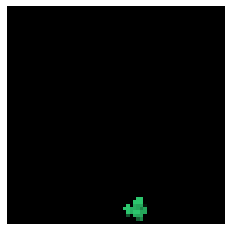

In [ ]:
obs = gym_env.reset() / 255.0
plt.imshow(obs)
plt.axis('off')
plt.show()

In [ ]:
obs, *_ = gym_env.step(0)
obs.shape

(64, 64, 3)

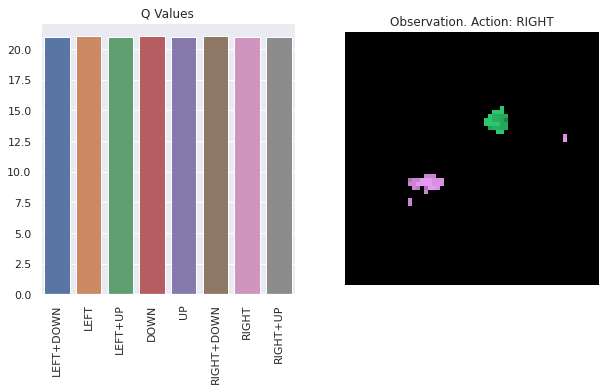

In [332]:
from IPython.display import clear_output
import numpy as np


try:
    obs = gym_env.reset() / 255.
    for _ in range(1000):
        _, q_vals = ProcgenProcessing.call(np.expand_dims(obs, 0))
        action = q_vals[ProcgenState.ACTIONS].argmax()
        obs, *_ = gym_env.step(ProcgenState.ACTIONS[action])
        obs = obs / 255.0

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # state = ProcgenState.extract_state(env)
        # obs = state.observation
        q_values = state.q_values[ProcgenState.ACTIONS]

        sns.barplot(x=np.arange(len(q_values)), y=q_values, ax=axs[0])
        axs[0].set_xticklabels(ProcgenState.COMBO_STRINGS, rotation=90)
        axs[0].set_title('Q Values')

        axs[1].imshow(np.clip(obs, 0, 1))
        axs[1].set_title(f'Observation. Action: {ProcgenState.COMBO_STRINGS[action]}')
        axs[1].axis('off')

        plt.show()

        clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [334]:
from mlrl.experiments.experiment_utils import create_meta_env


def create_procgen_meta_env():

    q_hat = lambda s, a: s.q_values[a]

    meta_config = {
        'expand_all_actions': True,
        'max_tree_size': 256
    }

    return create_meta_env(
        gym_env, ProcgenState.extract_state(gym_env),
        q_hat, meta_config,
        tree_policy_renderer=render_tree_policy,
        # min_computation_steps=min_computation_steps
    )

In [335]:
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy

In [336]:
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

In [337]:
tf_meta_env = BatchedPyEnvironment([GymWrapper(create_procgen_meta_env())])
tf_meta_env.reset();

In [338]:
a_star_policy = AStarPolicy(tf_meta_env)

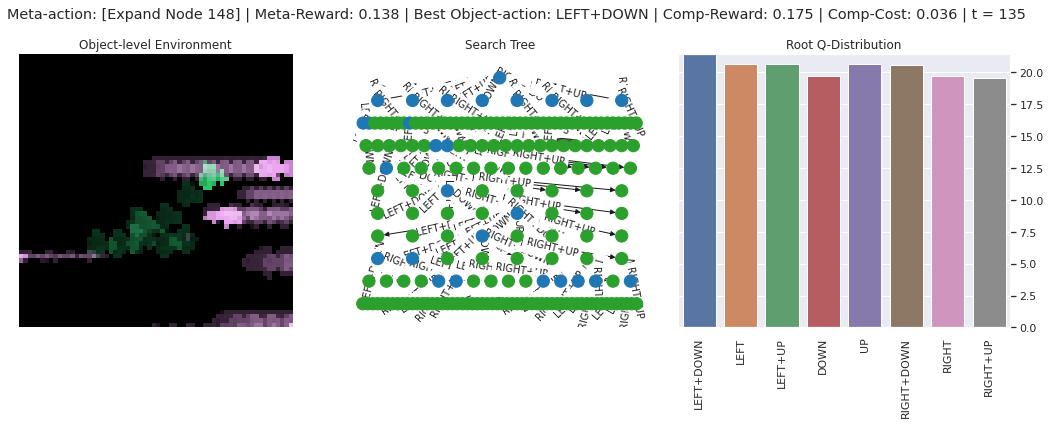

In [339]:
try:
    while True:
        ts = tf_meta_env.current_time_step()
        policy_step = a_star_policy.action(ts)
        tf_meta_env.step(policy_step.action)
        tf_meta_env.envs[0]._gym_env.render(plt_show=True)
        clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [341]:
len(tf_meta_env.envs[0]._gym_env.tree.node_list)

209

: 

: 

In [ ]:
meta_env.optimal_q_estimator.estimate_and_cache_optimal_q_values(meta_env.tree, verbose=True)

Estimating optimal Q-values for state ProcgenState(7355008026988006552) from nodes:
{ProcgenState(7355008026988006552)}
|---[LEFT+DOWN, 0.000, 29.605]--> (ProcgenState(607406626408513295))
|---[LEFT, 0.000, 29.686]--> (ProcgenState(-6621400740077553433))
|---[LEFT+UP, 0.000, 29.869]--> (ProcgenState(1659220527931673766))
|---[DOWN, 0.000, 29.486]--> (ProcgenState(5681159004581462653))
|---[UP, 0.000, 29.743]--> {ProcgenState(-2202294581451445338)}
	|---[LEFT+DOWN, 0.000, 29.925]--> (ProcgenState(7208280995384927489))
	|---[LEFT, 0.000, 29.818]--> (ProcgenState(-1089537303195000508))
	|---[LEFT+UP, 0.000, 30.043]--> (ProcgenState(-1505099161134523120))
	|---[DOWN, 0.000, 29.955]--> (ProcgenState(-1987799656323328063))
	|---[UP, 0.000, 29.753]--> (ProcgenState(395733177811555315))
	|---[RIGHT+DOWN, 0.000, 29.730]--> (ProcgenState(-8106061315876368812))
	|---[RIGHT, 0.000, 29.659]--> (ProcgenState(-4770044636537163075))
	|---[RIGHT+UP, 0.000, 29.503]--> (ProcgenState(7341145854990808432))